<a href="https://colab.research.google.com/github/Cairo-Henrique/Analise-Fundamentalista/blob/main/Portfolio_Optimization_with_PMFG_and_Sharpe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Portfolio Selection and Optimization Algorithm via Network Theory and Efficient Frontier**

This notebook implements an advanced portfolio construction strategy, utilizing topological graph filtering and centrality metrics to mitigate systemic risk within the stock market.

---

## **1. Selection Methodology**

This algorithm follows three fundamental stages:

### **A. Topological Filtering (PMFG)**

The raw correlation matrix is filtered using the **Planar Maximally Filtered Graph (PMFG)** algorithm. This technique extracts the "skeleton" of the market's strongest connections while maintaining graph planarity. This allows for the identification of sector clusters and essential connections that the raw matrix often obscures.

### **B. Centrality Selection (Investing in the Periphery)**

We use the **Node Strength** (Weighted Degree) metric as a centrality measure in relation to the network. The algorithm selects assets with the **lowest centrality**.

* **Thesis:** "Central" assets (Hubs) carry high systemic risk and tend to collapse together during crises. "Peripheral" assets offer genuine diversification and protection against contagion.

### **C. Robust Optimization**

To avoid excessive concentration, we choose the max Sharpe portfolio via efficient frontier optimization to define final weights.

---

## **2. Notebook Workflow**

1. **Data Ingestion:** Download of B3 tickers via `yfinance`.
2. **Filtering:** Construction of the PMFG graph and noise removal from the correlation matrix.
3. **Network Analysis:** Calculation of centrality metrics and identification of "Core" and "Periphery."
4. **Optimization:** Generation of Maximum Sharpe and Minimum Volatility portfolios.
5. **Backtest:** Comparison of accumulated performance against **IBOVESPA** and **CDI**.

---

## **3. Libraries Used**

* `PyPortfolioOpt`: For Efficient Frontier and HRP calculations.
* `NetworkX`: For construction and topological analysis of the PMFG graph.
* `yfinance`: For obtaining historical data.
* `pandas` & `numpy`: For time-series processing.
* `matplotlib` & `seaborn`: For data and network visualization.
* `requests`: To access the Central Bank (BCB) API.

---

### **How to Use**

1. Execute the dependency installation cells.
2. Define the analysis period in the parameters section.
3. The final graph will display a comparison of R$ 1.00 invested in the strategy versus the benchmarks.

In [ ]:
!pip install PyPortfolioOpt

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting
import requests

# **Correlation matrix of stock market**

[*                      3%                       ]  2 of 64 completed

Iniciando download...


[*********************100%***********************]  64 of 64 completed
ERROR:yfinance:
9 Failed downloads:
ERROR:yfinance:['STBP3.SA', 'EMBR3.SA', 'CPLE6.SA', 'ARZZ3.SA', 'JBSS3.SA', 'BRFS3.SA', 'TRPL4.SA', 'CRFB3.SA', 'ELET3.SA']: YFTzMissingError('possibly delisted; no timezone found')


Sucesso! Analisando 55 ativos (de 64 originais).
Matriz de Correlação:
Ticker     ABEV3.SA  ALOS3.SA  ASAI3.SA  B3SA3.SA  BBAS3.SA  BBDC4.SA  \
Ticker                                                                  
ABEV3.SA       1.00      0.37      0.27      0.37      0.35      0.39   
ALOS3.SA       0.37      1.00      0.41      0.65      0.40      0.53   
ASAI3.SA       0.27      0.41      1.00      0.33      0.24      0.29   
B3SA3.SA       0.37      0.65      0.33      1.00      0.42      0.61   
BBAS3.SA       0.35      0.40      0.24      0.42      1.00      0.44   
BBDC4.SA       0.39      0.53      0.29      0.61      0.44      1.00   
BBSE3.SA       0.22      0.21      0.13      0.26      0.28      0.21   
BEEF3.SA       0.22      0.18      0.20      0.26      0.33      0.24   
BPAC11.SA      0.41      0.62      0.35      0.70      0.48      0.63   
CMIG4.SA       0.34      0.47      0.36      0.40      0.38      0.33   
CPFE3.SA       0.27      0.46      0.35      0.41    

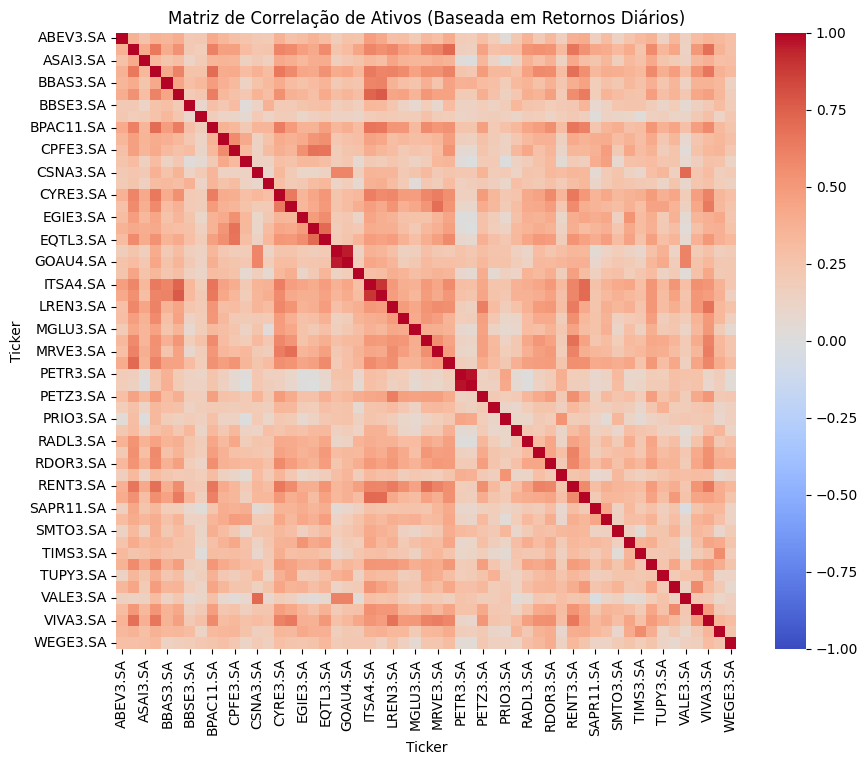

In [ ]:
# Definir Tickers
tickers = [
    "ITUB4.SA", "BBDC4.SA", "BBAS3.SA", "SANB11.SA", "BPAC11.SA",
    "ITSA4.SA", "BBSE3.SA", "PSSA3.SA", "CXSE3.SA", "B3SA3.SA",
    "VALE3.SA", "PETR4.SA", "PETR3.SA", "PRIO3.SA", "RECV3.SA",
    "VBBR3.SA", "UGPA3.SA", "CSNA3.SA", "GGBR4.SA", "GOAU4.SA",
    "ELET3.SA", "CPLE6.SA", "CMIG4.SA", "EQTL3.SA", "EGIE3.SA",
    "TRPL4.SA", "TAEE11.SA", "ENGI11.SA", "CPFE3.SA", "SBSP3.SA",
    "CSMG3.SA", "SAPR11.SA", "ABEV3.SA", "JBSS3.SA", "BRFS3.SA",
    "BEEF3.SA", "SMTO3.SA", "ASAI3.SA", "CRFB3.SA", "RADL3.SA",
    "HAPV3.SA", "RDOR3.SA", "WEGE3.SA", "EMBR3.SA", "POMO4.SA",
    "RENT3.SA", "MOVI3.SA", "RAIL3.SA", "STBP3.SA", "TUPY3.SA",
    "LREN3.SA", "MGLU3.SA", "ARZZ3.SA", "PETZ3.SA", "ALOS3.SA",
    "CYRE3.SA", "MRVE3.SA", "DIRR3.SA", "VIVA3.SA", "TOTS3.SA",
    "VIVT3.SA", "TIMS3.SA", "LWSA3.SA", "MULT3.SA"
]

# Definir datas para analisar dados do passado

start_past_data = "2023-01-01"
end_past_data = "2024-01-01"

#

print("Iniciando download...")
# auto_adjust=True evita o aviso de FutureWarning
data = yf.download(tickers, start=start_past_data, end=end_past_data, auto_adjust=True)['Close']

# LIMPEZA: Remove tickers que falharam (colunas vazias) ou têm muitos NaNs
data = data.dropna(axis=1, how='all')
data = data.dropna() # Remove dias sem dados em comum

print(f"Sucesso! Analisando {data.shape[1]} ativos (de {len(tickers)} originais).")

# Calcular Retornos Diários
# É crucial usar retornos (pct_change), não preços, para correlação real
returns = data.pct_change().dropna()

# Calcular Matriz de Correlação
corr_matrix = returns.corr()

# --- Exibição Numérica ---
print("Matriz de Correlação:")
print(corr_matrix.round(2))

# --- Exibição Visual (Heatmap) ---
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,
            annot=False,       # Escreve o valor nos quadrados
            cmap='coolwarm',  # Cores: Vermelho (alta) a Azul (baixa)
            vmin=-1, vmax=1,  # Escala fixa de -1 a 1
            fmt=".2f",        # 2 casas decimais
            linewidths=0,
            )

plt.title("Matriz de Correlação de Ativos (Baseada em Retornos Diários)")
plt.show()

# **Complex Networks Stock Selection**

#### **Topological Filtering (PMFG)**

The raw correlation matrix of the market is often noisy due to temporary price movements. We apply the **Planar Maximally Filtered Graph (PMFG)** algorithm to extract the "backbone" of the market. Unlike a Minimum Spanning Tree (MST), the PMFG allows for loops and cliques, preserving the essential clustering structure of sectors while maintaining planarity.

* **Scientific Basis:** *Tumminello et al. (2005)* demonstrated that PMFG is a robust tool for filtering information in complex systems, providing a clearer view of the hierarchical structure of financial markets than raw matrices.

#### **Peripheral Asset Selection (Node Strength)**

Once the PMFG is constructed, we calculate the **Node Strength** (Weighted Degree Centrality) for each stock. We specifically target assets in the **periphery** of the network (those with the lowest centrality).

* **Why Periphery?** Research by *Pozzi, Di Matteo, and Aste (2013)* in *Scientific Reports* found that "hubs" (central assets) carry high systemic risk; consequently, they are the first to collapse in a market-wide crisis. Therefore, peripheral assets possess dynamics that offer genuine diversification.

### **Citations**

* **Tumminello, M., Aste, T., Di Matteo, T., & Mantegna, R. N. (2005).** "A tool for filtering information in complex systems." *Proceedings of the National Academy of Sciences (PNAS)*.
* **Pozzi, F., Di Matteo, T., & Aste, T. (2013).** "Spread of risk across financial markets: better to invest in the peripheries." *Scientific Reports*.

In [ ]:
G = nx.Graph(corr_matrix)
G.remove_edges_from(nx.selfloop_edges(G))

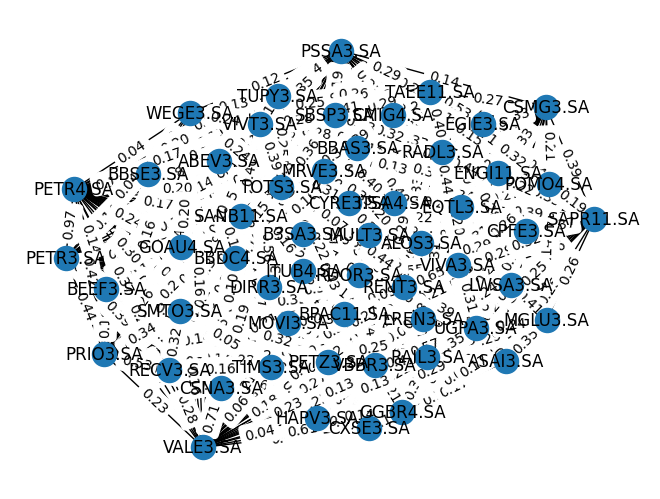

In [ ]:
# Exhibit
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw(G, pos, with_labels=True,)

# Draw edge labels (correlations)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()}
)

plt.show()

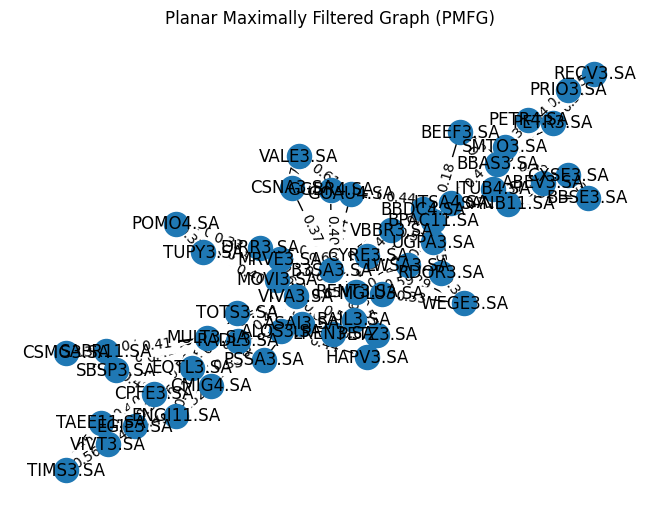

In [ ]:
def get_pmfg(corr_matrix):
    # Make a copy to avoid modifying the original corr_matrix
    temp_corr_matrix = corr_matrix.copy()
    # Clear the index name to prevent collision with column name 'Ticker' during reset_index()
    temp_corr_matrix.index.name = None

    # Organizar todas as correlações em ordem decrescente
    edges = temp_corr_matrix.stack().reset_index()
    edges.columns = ['node1', 'node2', 'weight']

    # Remover auto-correlação (diagonal) e duplicatas (A-B vs B-A)
    edges = edges[edges['node1'] < edges['node2']]
    edges = edges.sort_values(by='weight', ascending=False)

    # Inicializar o Grafo
    G_pmfg = nx.Graph()
    G_pmfg.add_nodes_from(corr_matrix.columns)

    # O limite teórico de arestas para um grafo planar é 3(n-2)
    n = len(corr_matrix.columns)
    max_edges = 3 * (n - 2)

    # Greedy Algorithm: Adiciona a aresta se o grafo continuar sendo planar
    for _, row in edges.iterrows():
        if G_pmfg.number_of_edges() >= max_edges:
            break

        G_pmfg.add_edge(row['node1'], row['node2'], weight=row['weight'])

        # Teste de Planaridade
        is_planar, _ = nx.check_planarity(G_pmfg)

        if not is_planar:
            G_pmfg.remove_edge(row['node1'], row['node2'])

    return G_pmfg

G_pmfg = get_pmfg(corr_matrix)

# Plotagem
pos = nx.spring_layout(G_pmfg)

nx.draw(G_pmfg, pos, with_labels=True)

# Mostrar os valores das correlações nas arestas do PMFG
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G_pmfg.edges(data=True)}
nx.draw_networkx_edge_labels(G_pmfg, pos, edge_labels=edge_labels, font_size=10)

plt.title("Planar Maximally Filtered Graph (PMFG)")
plt.show()

In [ ]:
# Calcular Node Strength (Grau Ponderado)
strength_dict = dict(G_pmfg.degree(weight='weight'))

# Converter para Pandas Series e Ordenar
centrality_strength = pd.Series(strength_dict, name="Node Strength")

# Selecionar a Periferia (Menores valores)
periphery_assets = centrality_strength.sort_values(ascending=True)

# Número de ações no portfolio
N = 10

print(f"--- TOP {N} Ativos da Periferia (Melhores para Diversificação) ---")
print(periphery_assets.head(N))

tickers = periphery_assets.head(N).index.tolist()
print(tickers)

--- TOP 10 Ativos da Periferia (Melhores para Diversificação) ---
BEEF3.SA    0.721093
PSSA3.SA    0.968747
WEGE3.SA    1.013420
BBSE3.SA    1.018892
POMO4.SA    1.019611
CSMG3.SA    1.203020
TIMS3.SA    1.206644
HAPV3.SA    1.225969
ASAI3.SA    1.264053
RECV3.SA    1.283828
Name: Node Strength, dtype: float64
['BEEF3.SA', 'PSSA3.SA', 'WEGE3.SA', 'BBSE3.SA', 'POMO4.SA', 'CSMG3.SA', 'TIMS3.SA', 'HAPV3.SA', 'ASAI3.SA', 'RECV3.SA']


/tmp/ipython-input-93720815.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_for_cov = yf.download(ordered_tickers, start="2022-01-01", end="2023-01-01")['Close'] # Use a mesma data de start do corr_matrix
[*********************100%***********************]  10 of 10 completed


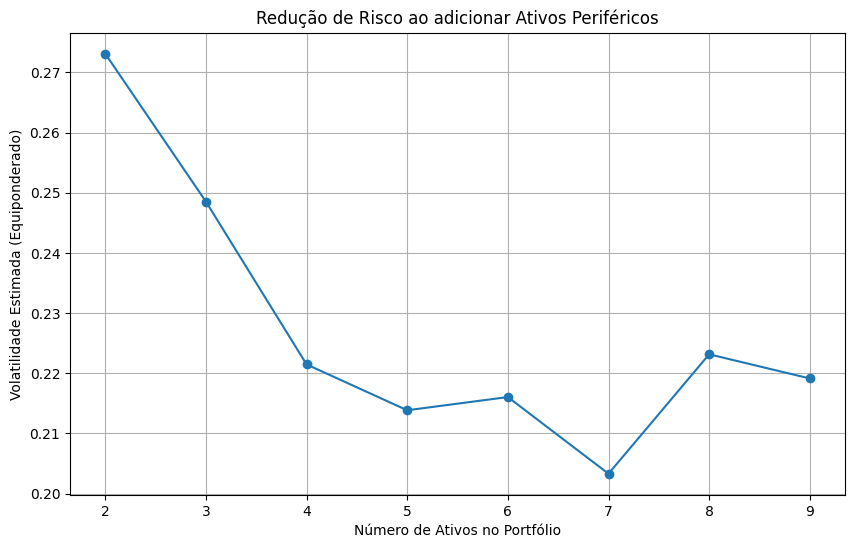

In [ ]:
def calculate_vol_reduction(cov_matrix, ordered_tickers):
    volatilities = []
    nums = []

    # Testa portfólios de tamanho 2 até tamanho 40 (ou o total de ativos)
    max_test = min(40, len(ordered_tickers))

    for n in range(2, max_test):
        # Seleciona os top N tickers
        selected = ordered_tickers[:n]

        # Cria um portfólio equiponderado (1/N) para simplificar o teste
        weights = np.ones(n) / n

        # Fatia a matriz de covariância para esses ativos
        sub_cov = cov_matrix.loc[selected, selected]

        # Calcula volatilidade do portfólio: sqrt(w.T * S * w)
        vol = np.sqrt(weights.T @ sub_cov @ weights)

        volatilities.append(vol)
        nums.append(n)

    return nums, volatilities

# --- Execução ---
# 1. Pegue a lista ordenada de nomes (índices da sua Series de centralidade)
ordered_tickers = tickers

# 2. Recalcule a matriz de covariância 'S' para os ativos corretos
# Baixe os dados para os ordered_tickers
df_for_cov = yf.download(ordered_tickers, start="2022-01-01", end="2023-01-01")['Close'] # Use a mesma data de start do corr_matrix
S = risk_models.sample_cov(df_for_cov)

# Calcule a curva
ns, vols = calculate_vol_reduction(S, ordered_tickers)

# 3. Plotar
plt.figure(figsize=(10, 6))
plt.plot(ns, vols, marker='o')
plt.title("Redução de Risco ao adicionar Ativos Periféricos")
plt.xlabel("Número de Ativos no Portfólio")
plt.ylabel("Volatilidade Estimada (Equiponderado)")
plt.grid(True)
plt.show()

# **Portfolio Optimization using Efficient Frontier**

/tmp/ipython-input-2524892710.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start_past_data, end=end_past_data)['Close']
[*********************100%***********************]  10 of 10 completed


Portfólio de MÍNIMA VARIÂNCIA:
          Percentual (%)
BBSE3.SA           28.42
PSSA3.SA           17.52
TIMS3.SA           16.57
WEGE3.SA           15.71
CSMG3.SA           11.33
POMO4.SA            5.53
BEEF3.SA            3.88
RECV3.SA            1.04
ASAI3.SA            0.00
HAPV3.SA            0.00

Portfólio de MÁXIMA SHARPE:
          Percentual (%)
POMO4.SA           50.74
TIMS3.SA           41.85
PSSA3.SA            5.44
CSMG3.SA            1.97
BBSE3.SA            0.00
ASAI3.SA            0.00
HAPV3.SA            0.00
BEEF3.SA            0.00
RECV3.SA            0.00
WEGE3.SA            0.00

Métrica dos portfólios destacados:
Min Vol -> Retorno: 0.3618, Vol: 0.1370, Sharpe: 2.6412
Max Sharpe -> Retorno: 1.2793, Vol: 0.2184, Sharpe: 5.8576


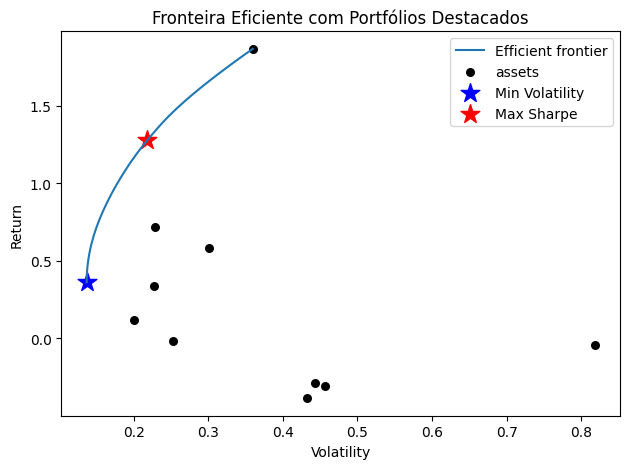

In [ ]:
df = yf.download(tickers, start=start_past_data, end=end_past_data)['Close']

mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# --- CÁLCULO: MÍNIMA VARIÂNCIA ---
ef_min = EfficientFrontier(mu, S)
weights_min = ef_min.min_volatility()
perf_min = ef_min.portfolio_performance()

# --- CÁLCULO: MÁXIMA SHARPE ---
ef_max = EfficientFrontier(mu, S)
weights_max = ef_max.max_sharpe()
perf_max = ef_max.portfolio_performance()

# --- FORMATAÇÃO DO PRINT ---
def format_weights(weights):
    df_w = pd.DataFrame.from_dict(weights, orient='index', columns=['Percentual (%)'])
    df_w['Percentual (%)'] = (df_w['Percentual (%)'] * 100).round(2)
    return df_w.sort_values(by='Percentual (%)', ascending=False)

print("Portfólio de MÍNIMA VARIÂNCIA:")
print(format_weights(weights_min))
print("\nPortfólio de MÁXIMA SHARPE:")
print(format_weights(weights_max))

print("\nMétrica dos portfólios destacados:")
print(f"Min Vol -> Retorno: {perf_min[0]:.4f}, Vol: {perf_min[1]:.4f}, Sharpe: {perf_min[2]:.4f}")
print(f"Max Sharpe -> Retorno: {perf_max[0]:.4f}, Vol: {perf_max[1]:.4f}, Sharpe: {perf_max[2]:.4f}")

# --- GRÁFICO ---
fig, ax = plt.subplots()
ef_plot = EfficientFrontier(mu, S) # Nova instância para o plot
plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=True)

# Adicionar as estrelas
ax.scatter(perf_min[1], perf_min[0], marker="*", s=200, c="blue", label="Min Volatility")
ax.scatter(perf_max[1], perf_max[0], marker="*", s=200, c="red", label="Max Sharpe")

ax.set_title("Fronteira Eficiente com Portfólios Destacados")
ax.legend()
plt.tight_layout()
plt.show()

# **Simulation**

/tmp/ipython-input-4152782451.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_max_assets = yf.download(list(weights_max.keys()), start=start_simulation, end=end_simulation)['Close']
[*********************100%***********************]  10 of 10 completed
/tmp/ipython-input-4152782451.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_min_assets = yf.download(list(weights_min.keys()), start=start_simulation, end=end_simulation)['Close']
[*********************100%***********************]  10 of 10 completed
/tmp/ipython-input-4152782451.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_benchmark = yf.download("^BVSP", start=start_simulation, end=end_simulation)['Close']
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated a

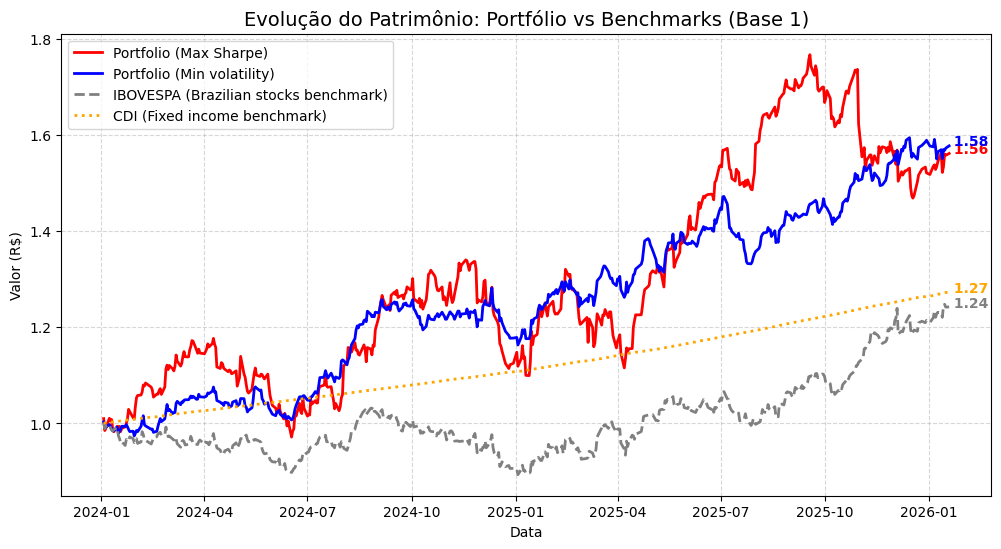

In [ ]:
# ---FUNÇÃO AUXILIAR PARA CDI ---
def get_cdi_acumulado(start_date, end_date):
    # Converte datas de YYYY-MM-DD para DD/MM/YYYY (formato da API do BC)
    start_br = pd.to_datetime(start_date).strftime('%d/%m/%Y')
    end_br = pd.to_datetime(end_date).strftime('%d/%m/%Y')
    url = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.12/dados?formato=json&dataInicial={start_br}&dataFinal={end_br}"

    data = requests.get(url).json()
    df_cdi = pd.DataFrame(data)
    df_cdi['data'] = pd.to_datetime(df_cdi['data'], dayfirst=True)
    df_cdi['valor'] = df_cdi['valor'].astype(float) / 100 # Converte % para decimal
    df_cdi.set_index('data', inplace=True)
    return df_cdi['valor']

# Datas para simulação
start_simulation = "2024-01-01"
end_simulation = "2026-01-20"

# Baixa ações do portfólio e os Benchmarks
df_max_assets = yf.download(list(weights_max.keys()), start=start_simulation, end=end_simulation)['Close']
df_min_assets = yf.download(list(weights_min.keys()), start=start_simulation, end=end_simulation)['Close']
df_benchmark = yf.download("^BVSP", start=start_simulation, end=end_simulation)['Close']
cdi_diario = get_cdi_acumulado(start_simulation, end_simulation)

# --- CÁLCULO DE RETORNOS ---
rets_max_assets = df_max_assets.pct_change().dropna()
rets_min_assets = df_min_assets.pct_change().dropna()
rets_benchmark = df_benchmark.pct_change().dropna()

# Alinhar as datas (Portfólio, IBOV e CDI)
rets_max_assets, rets_benchmark = rets_max_assets.align(rets_benchmark, join='inner', axis=0)
rets_max_assets, cdi_diario = rets_max_assets.align(cdi_diario, join='inner', axis=0)
rets_max_assets, rets_min_assets = rets_max_assets.align(rets_min_assets, join='inner', axis=0)

# --- CÁLCULO DO PORTFÓLIO ---
w_max_series = pd.Series(weights_max)
max_portfolio_rets = rets_max_assets.dot(w_max_series)

w_min_series = pd.Series(weights_min)
min_portfolio_rets = rets_min_assets.dot(w_min_series)

# --- NORMALIZAÇÃO (Base 1,00 real) ---
max_portfolio_value = 1 * (1 + max_portfolio_rets).cumprod()
min_portfolio_value = 1 * (1 + min_portfolio_rets).cumprod()
benchmark_value = 1 * (1 + rets_benchmark).cumprod()
cdi_value = 1 * (1 + cdi_diario).cumprod()

# --- PLOTAGEM ---
plt.figure(figsize=(12, 6))

plt.plot(max_portfolio_value, label="Portfolio (Max Sharpe)", linewidth=2, color="red")
plt.plot(min_portfolio_value, label="Portfolio (Min volatility)", linewidth=2, color="blue")
plt.plot(benchmark_value, label="IBOVESPA (Brazilian stocks benchmark)", linewidth=2, color="gray", linestyle="--")
plt.plot(cdi_value, label="CDI (Fixed income benchmark)", linewidth=2, color="orange", linestyle=":")

plt.title("Evolução do Patrimônio: Portfólio vs Benchmarks (Base 1)", fontsize=14)
plt.ylabel("Valor (R$)")
plt.xlabel("Data")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Destaque de retorno final
final_max_port = max_portfolio_value.iloc[-1]
final_min_port = min_portfolio_value.iloc[-1]
final_bench = benchmark_value.iloc[-1]
final_cdi = cdi_value.iloc[-1]

plt.text(max_portfolio_value.index[-1], final_max_port, f" {final_max_port.item():.2f}", color="red", fontweight="bold")
plt.text(min_portfolio_value.index[-1], final_min_port, f" {final_min_port.item():.2f}", color="blue", fontweight="bold")
plt.text(benchmark_value.index[-1], final_bench, f" {final_bench.item():.2f}", color="gray", fontweight="bold")
plt.text(cdi_value.index[-1], final_cdi, f" {final_cdi.item():.2f}", color="orange", fontweight="bold")

plt.show()